# Performance Plots

In [1]:
import pathlib

# wiki, version, langcode = 'simplewiki', '20211120', 'en'
# wiki, version, langcode = 'tawiki', '20220301', 'ta'
# wiki, version, langcode = 'fawiki', '20220301', 'fa'
# wiki, version, langcode = 'trwiki', '20220301', 'tr'
# wiki, version, langcode = 'nlwiki', '20220301', 'nl'
# wiki, version, langcode = 'arwiki', '20220301', 'ar'
# wiki, version, langcode = 'srwiki', '20220301', 'sr'
# wiki, version, langcode = 'eswiki', '20220301', 'es'
# wiki, version, langcode = 'jawiki', '20220301', 'ja'
# wiki, version, langcode = 'dewiki', '20220301', 'de'
usefeats = False


# fpreds = sorted(pathlib.Path(f"wiki/{wiki}-{version}/experiments/").glob("*.tsv"))
# fgold = pathlib.Path(f"evaluation/Mewsli-9/{langcode}.tsv")

fpreds = sorted(pathlib.Path("../data/wiki/simplewiki-20211120/").rglob("predictions.tsv"))
fgold = pathlib.Path("../data/mewsli-en-small.tsv")

from minimel import evaluate

df = evaluate(fgold, *fpreds)

Evaluating: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


In [11]:
import pandas as pd

# Load ablations
abl = pd.Series(df.index).str.extract(
    "pred-mewsli."
    "(?P<kind>\w+)"
    "-?(?P<q>q0.25|q0.5|q1)?"
    "(?P<f>.feat-clean-q1\.p[.0-9]+?)?"
    "(?P<b>.\d+b)?"
    "(?P<c>\..*?)?$"
)
abl["c"] = abl["c"].fillna("")
abl["c"] = abl.apply(
    lambda s: (s["c"] != "") if s["kind"] not in ["base", "upper"] else s["c"], axis=1
)
abl["b"] = abl["b"].str[1:-1].astype("float").astype("Int32")
abl["f"] = abl["f"].fillna("")
abl["kind"] = abl["kind"].replace("stem", "clean-stem")


f1 = df.set_index(pd.MultiIndex.from_frame(abl))[("micro", "fscore")].rename("f1")

f = (
    (f1.index.get_level_values("f") != "")
    if usefeats
    else (f1.index.get_level_values("f") == "")
)
d = (f1.index.get_level_values("kind") == "base") | (
    f1.index.get_level_values("kind") == "upper"
)
f1 = f1[d | f]
f1 = f1.droplevel("f")
f1

kind  q    b     c    
NaN   NaN  <NA>  False    0.479931
Name: f1, dtype: float64

In [7]:
f1.loc["base"].sort_index()

q    b    c             
NaN  NaN                    0.803648
          .clean-q1         0.838007
          .clean-stem-q1    0.828918
Name: f1, dtype: float64

/tmp/ipykernel_18305/2362728954.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(l)


<Figure size 864x576 with 0 Axes>

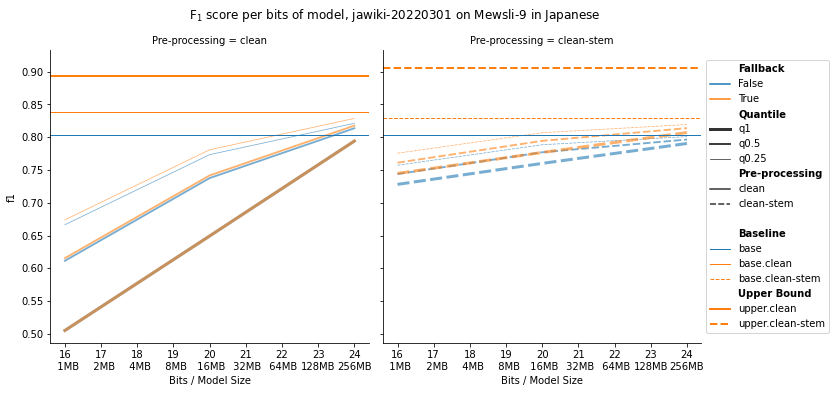

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# PLOTTING

data = (
    f1[f1.index.drop(["base", "upper"])]
    .reset_index()
    .rename(
        columns={
            "c": "Fallback",
            "q": "Quantile",
            "b": "Bits",
            "kind": "Pre-processing",
        }
    )
    .sort_values(["Pre-processing", "Quantile"], ascending=[1, 0])
)

fig = plt.figure(figsize=(12, 8))
g = sns.relplot(
    kind="line",
    data=data,
    x="Bits",
    y="f1",
    hue="Fallback",
    col="Pre-processing",
    style="Pre-processing",
    size="Quantile",
    alpha=0.6,
)

handles, labels = g._legend.get_lines(), [t.get_text() for t in g._legend.get_texts()]
handles.append(handles[0]), labels.append("")

handles.append(handles[0]), labels.append("Baseline")
for (_, _, c), basef1 in f1.loc["base"].sort_index().iteritems():
    ls = "--" if ("stem" in c) else "-"
    color = "C1" if c else "C0"
    label = f"base{c[:-3]}"
    for ax in g.axes.flatten():
        if (not c) or (("stem" in c) == ("stem" in ax.get_title())):
            h = ax.axhline(basef1, ls=ls, linewidth=1, color=color, label=label)
    handles.append(h)
    labels.append(label)

handles.append(handles[0]), labels.append("Upper Bound")
for (_, _, c), basef1 in f1.loc["upper"].sort_index().iteritems():
    ls = "--" if ("stem" in c) else "-"
    color = "C1" if c else "C0"
    label = f"upper{c[:-3]}"
    for ax in g.axes.flatten():
        if (not c) or (("stem" in c) == ("stem" in ax.get_title())):
            h = ax.axhline(basef1, ls=ls, linewidth=2, color=color, label=label)
    handles.append(h)
    labels.append(label)

g._legend.remove()
legend = plt.legend(
    handles=handles, labels=labels, loc="center left", bbox_to_anchor=(1, 0.5)
)
for h, text in zip(handles, legend.get_texts()):
    if not h.get_visible():
        text.set_fontweight("bold")
y0, y1 = ax.get_ylim()
ax.set_ylim([y0, y1 + 0.02])


def sizeof_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:3.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"


for ax in g.axes.flatten():
    l = [f"{int(x)}\n{sizeof_fmt(2**x*16)}" for x in ax.get_xticks()]
    ax.set_xticklabels(l)
    ax.set_xlabel("Bits / Model Size")

from minimel import code_name

code_name["fa"] = "Persian"
code_name["ja"] = "Japanese"
langname = code_name.get(langcode).title()
g.figure.suptitle(
    f"F$_1$ score per bits of model, {wiki}-{version} on Mewsli-9 in {langname}", y=1.05
)

plt.rcParams["pgf.texsystem"] = "pdflatex"
plt.savefig(f"paper/fig/{wiki}-{version}.pgf", bbox_inches="tight")
None

## Unobserved mentions

In [4]:
import pandas as pd
import json, glob, dawg
from minimel.normalize import normalize

counts = json.load(open(f"wiki/{wiki}-{version}/experiments/clean-q1.json"))
disambig = set(pd.read_csv("data/wikidata-20211122-disambig.txt", header=None)[0])
index = glob.glob(f"wiki/{wiki}-*/index_{wiki}-*.dawg")[0]
wm = dawg.IntDAWG().load(index)


def rank(wm, counts, surface, i, stem=None):
    """Return count and rank (rank = -1 means only in page title index)"""
    for norm in normalize(surface, language=stem):
        norm = norm.lower()
        ent_count = counts.get(norm, {})
        if len(ent_count) == 1 and ent_count.get("%s" % i):
            return ent_count["%s" % i], -1
        if ent_count.get("%s" % i):
            order = sorted(ent_count, key=lambda x: -ent_count[x])
            return ent_count["%s" % i], order.index("%s" % i)
    if wm.get(surface[0].upper() + surface[1:].replace(" ", "_")) == i:
        return 1, -1
    return 0, None


ranks = pd.DataFrame(
    [
        (surface, ref, *rank(wm, counts, surface, ref))
        for _, links, text in (l.split("\t") for l in fgold.open())
        for surface, ref in json.loads(links).items()
        if ref not in disambig
    ],
    columns=["surface", "ref", "count", "rank"],
)

In [5]:
test_counts = ranks.fillna("na").value_counts().rename("test_count").reset_index()
test_counts.query('(count == 0) & (rank == "na")').head(20)

,surface,ref,count,rank,test_count
130,Netanyahu,43723,0,na,6
136,IMF,7804,0,na,6
161,Allahoe akbar,191811,0,na,6
171,Grapperhaus,2195581,0,na,6
178,Uber,780442,0,na,5
223,Poetin,7747,0,na,5
280,Khamenei,57336,0,na,4
288,Rohani,348144,0,na,4
317,Tham Luang,14752104,0,na,4
327,Nations League,29000951,0,na,4


## Hardest entities

In [6]:
hard_ents = test_counts.query("rank==1")["surface"]
test_counts.set_index("surface").loc[list(hard_ents)]

,ref,count,rank,test_count
surface,,,,
Openbaar Ministerie,2595790,554,0.0,19
Openbaar Ministerie,11775750,313,1.0,6
China,148,6408,1.0,5
China,29520,8213,0.0,5
Peter Madsen,2076849,11,1.0,5
...,...,...,...,...
Koninginnedag,333016,213,0.0,1
Koenders,3023616,3,1.0,1
Kodiak,79985,23,1.0,1
